[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/example_notebooks/autoregression_yosemite_temps.ipynb)

# Autoregression
Here we fit NeuralProphet to data with 5-minute resolution (daily temperatures at Yosemite). 

In [1]:
# install NeuralProphet from our repository
!pip install git+https://github.com/adasegroup/neural_prophet.git # may take a while

In [2]:
if 'google.colab' in str(get_ipython()):
    data_location = "https://raw.githubusercontent.com/adasegroup/neural_prophet/master/"
else:
    data_location = "../"

In [3]:
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet.utils.utils import set_log_level
# set_log_level("ERROR")
df = pd.read_csv(data_location + "example_data/yosemite_temps.csv")
df.head(3)


,ds,y
0,2017-05-01 00:00:00,27.8
1,2017-05-01 00:05:00,27.0
2,2017-05-01 00:10:00,26.8


## Next-step forecast
Based on our first contact with the data, we set:
* First, we disable `weekly_seasonality`, as nature does not follow the human week's calendar.
* Second, we increase `n_changepoints`, and increase `changepoints_range`, as we are doing short-term predictions.

Further, we can make use of the fact that tomorrow's weather is most likely similar to yesterdays weather.
This means that we will regress our time series on it's most recent past values, also known as autoregression.

We can achieve this by setting `n_lags` to the desired number of past observations to regress over. This value is also known as the 'AR order'. 

Here, we predict the temperature in the next 5 minutes based on the last hour:


In [4]:
m = NeuralProphet(
    n_lags=12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=64,
    epochs=10,
    learning_rate=1.0,
)
metrics = m.fit(df, freq='5min')

INFO - (NP.forecaster._handle_missing_data) - 12 NaN values in column y were auto-imputed.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
  0%|          | 0/10 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


  | Name          | Type          | Params
------------------------------------------------
0 | season_params | ParameterDict | 12    
1 | ar_net        | ModuleList    | 12    
2 | loss_func     | SmoothL1Loss  | 0     
------------------------------------------------
57        Trainable params
0         Non-trainable params
57        Total params
0.000     Total estim

Validation sanity check: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Training: 0it [00:00, ?it/s]

In [5]:
metrics

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.429323,40.758965,3645.252302,0.0
1,0.079827,15.046210,510.615305,0.0
2,0.017164,7.062554,102.379452,0.0
3,0.004057,3.557258,24.189658,0.0
4,0.001883,2.484484,11.224241,0.0
5,0.001272,2.051698,7.584490,0.0
6,0.000953,1.745132,5.679271,0.0
7,0.000740,1.510040,4.413121,0.0
8,0.000582,1.313836,3.469349,0.0
9,0.000462,1.149298,2.753042,0.0


Please note that a model with an autoregressive component can be harder to fit. The automatic selection of hyperparameters may not lead to ideal results. For best results, consider changing these manually (in order of importance):
* `learning_rate`
* `epochs`
* `batch_size`

The automatically set hyperparameters (printed out as 'INFO' level logs) can serve as a good starting point.

INFO - (NP.forecaster._handle_missing_data) - 12 NaN values in column y were auto-imputed.
  0%|          | 0/10 [00:20<?, ?it/s]


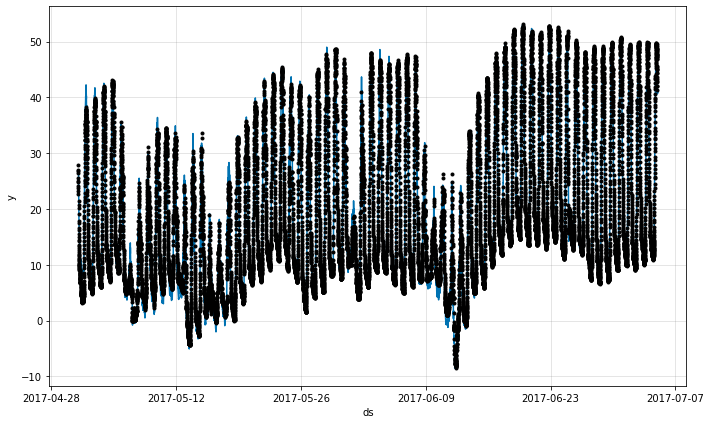

In [6]:
future = m.make_future_dataframe(df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

The predictions are now very precise, but this is not a big surprise, as we are just forecasting the very next 5 minutes.

When plotting the model parameters, the panel 'AR weight' displays the weight given to the 12 last observed values, these can be interpreted as our 'AR coefficients':

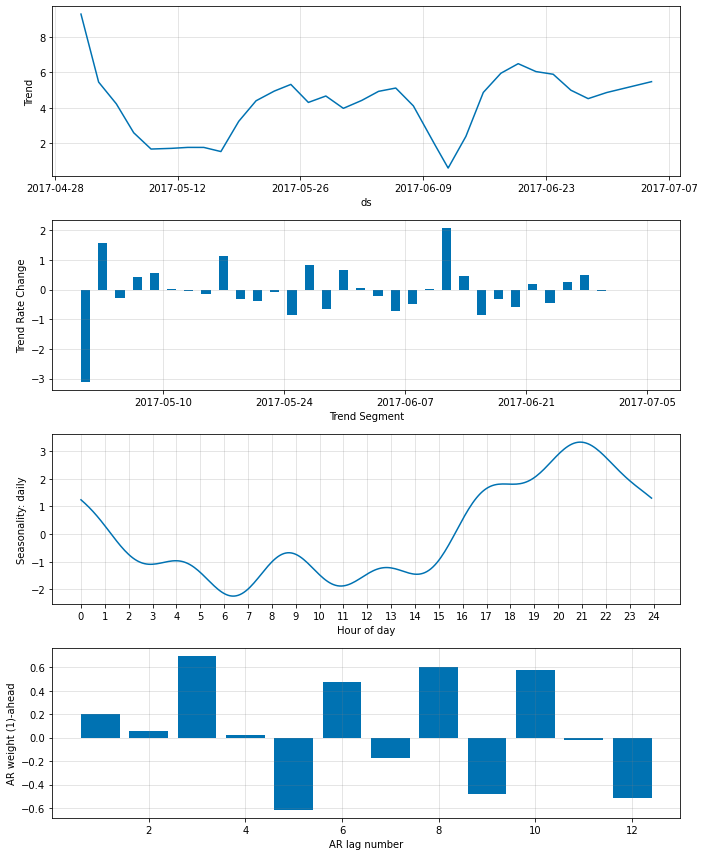

In [10]:
# fig_comp = m.plot_components(forecast)
m = m.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = m.plot_parameters()

The 'AR weight' plot shows that the most recent observations are given significantly more weight compared to more distant observations.

## Multi-step forecast
To predict multiple steps into the future, we could 'unroll' our single-step model, by predicting a step ahead, adding the forecasted value to our data, and then forecasting the next step until we reach the horizon we are interested in. 
However, there is a better way to do this: We can directly forecast multiple steps ahead with NeuralProphet.

We can set `n_forecasts` to the desired number of steps we would like to forecast (also known as 'forecast horizon').
NeuralProphet will forecast `n_forecasts` steps into the future, at every single step. Thus, we have `n_forecasts` overlapping predictions of vaying age at every historic point. 

When icreasing the forecast horizon `n_forecasts`, we should also increase the number of past observations `n_lags` to at least the same value.

Here, we forecast the next 3 hours based on the last observed 6 hours, in 5-minute steps:


INFO - (NP.forecaster._handle_missing_data) - 12 NaN values in column y were auto-imputed.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
  0%|          | 0/10 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


  | Name          | Type          | Params
------------------------------------------------
0 | season_params | ParameterDict | 12    
1 | ar_net        | ModuleList    | 2.6 K 
2 | loss_func     | SmoothL1Loss  | 0     
------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.011     Total estim

Validation sanity check: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Training: 0it [00:00, ?it/s]

  0%|          | 0/10 [00:16<?, ?it/s]
INFO - (NP.forecaster._handle_missing_data) - 12 NaN values in column y were auto-imputed.


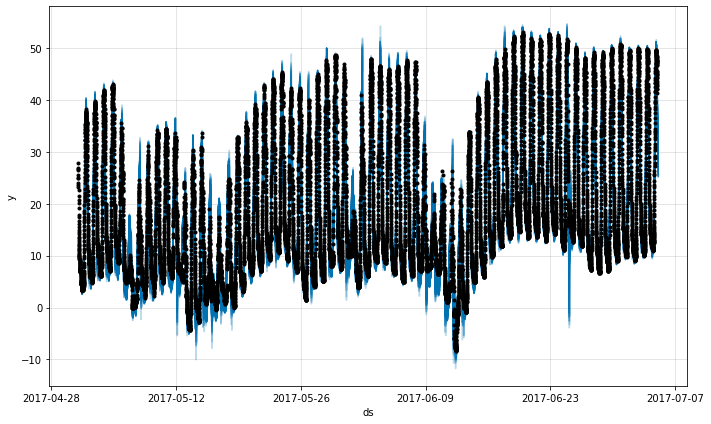

In [11]:
m = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=64,
    epochs=10,    
    learning_rate=1.0,
)
metrics = m.fit(df, freq='5min')
future = m.make_future_dataframe(df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

We see that our forecast sometimes miss-predicts for a day and then returns again to more accurate forecasts. Let's have a closer look at that over-prediction on day 6 of our data:

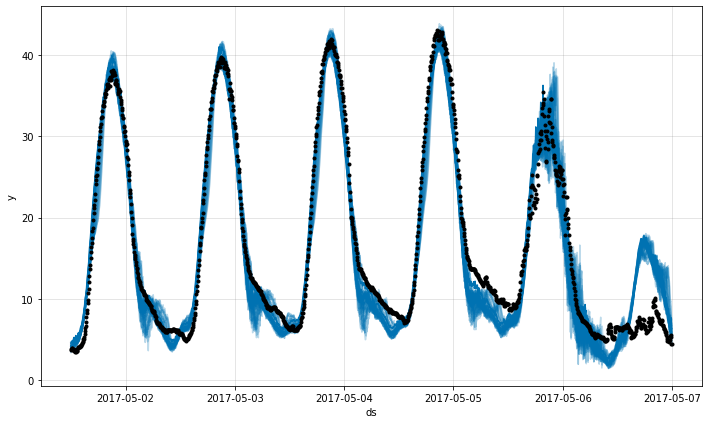

In [12]:
fig = m.plot(forecast[144:6*288])

On day 6, the redorded temperature drops at nighttime. Based on the observed lower nighttime temperatures, our model predicts a lower daytime peak. However, the actual daytime temperatures are anomalously low, barely higher than during the night. Thus, leading to an overprediction.

We can again visualize the relative importance of the lags:

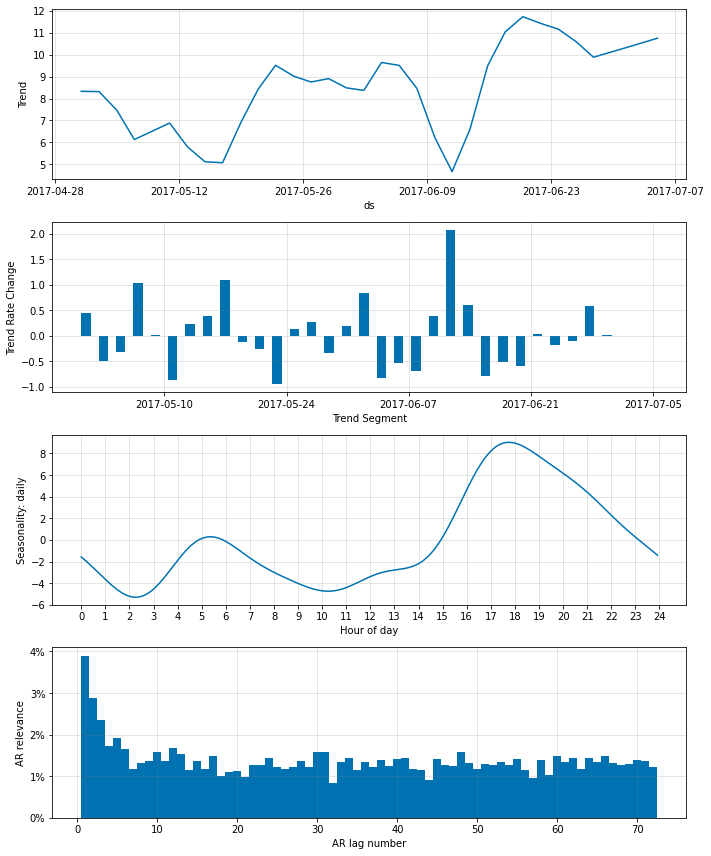

In [13]:
# fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

Note that the 'AR relevance' is the relative importance of a lag, averaged over all `n_forecasts`.

## Reviewing a specific forecast step
We can have a closer look at a particular forecast horizon by highlighting the n-th step ahead of each forecast. Here we focus on the temperature predicted 3 hours ahead (most distant prediction into the future). Let's have a closer look at the weights for the different 3 hour ahead forecast:

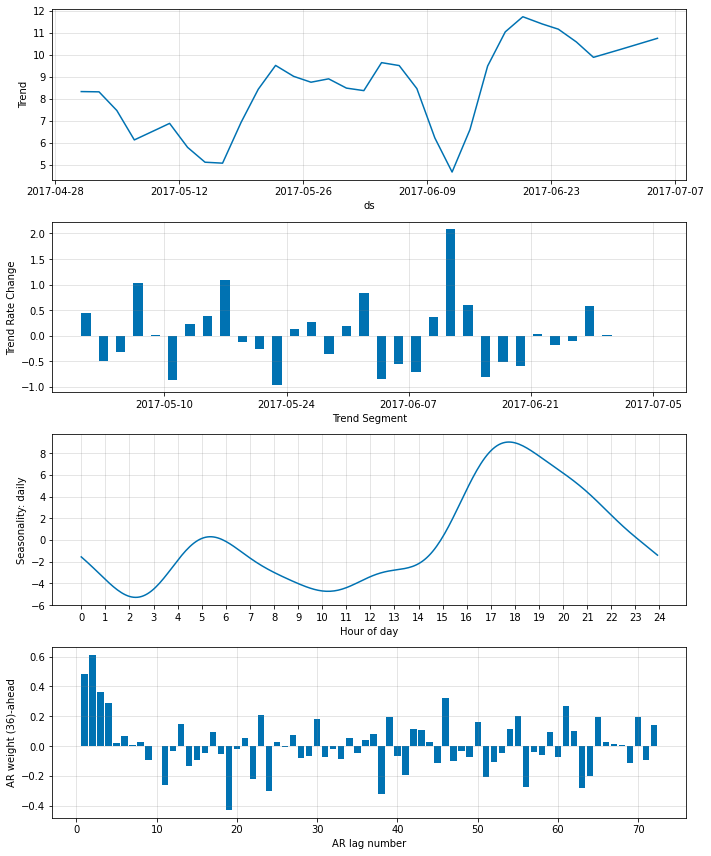

In [14]:
m = m.highlight_nth_step_ahead_of_each_forecast(3*12)
fig_param = m.plot_parameters()

Next, we replot the first 6 days and compare it to the forecast one-step-ahead. We observe the single-step ahead forecast to be much more accurate compared to the 3 hour ahead forecast. However, neither is able to forecast the anomaly on day 6.

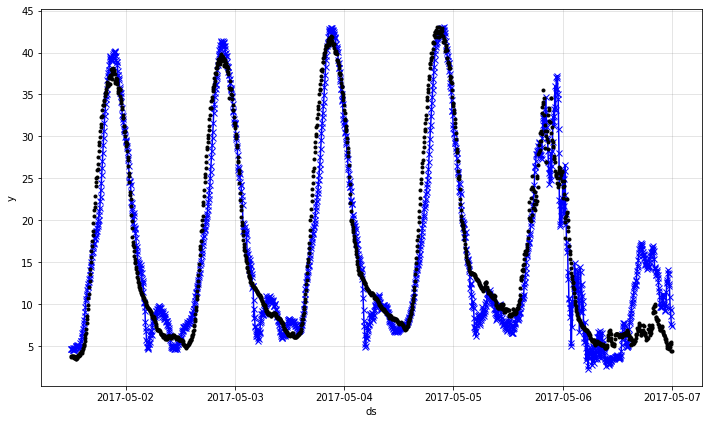

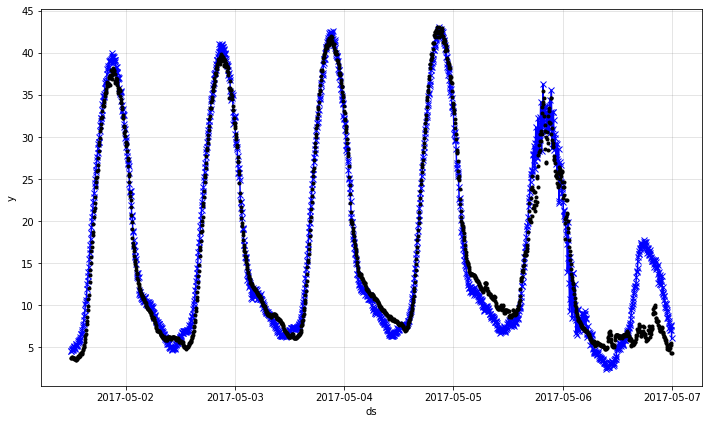

In [15]:
fig = m.plot(forecast[144:6*288])
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[144:6*288])

## Plotting the most recent forecast
When we are more concerned with our actual forecast than the model fit, we can plot the last most recent forecast:

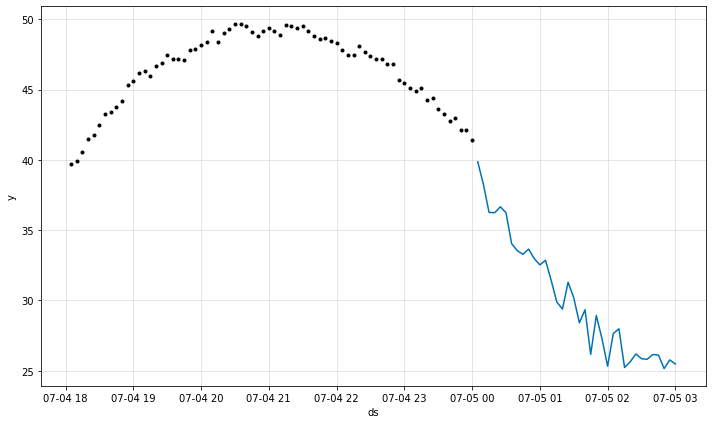

In [16]:
m = m.highlight_nth_step_ahead_of_each_forecast(None) # reset highlight
fig = m.plot_last_forecast(forecast)

The last few historic forecasts can be included to assess how the forecast has changed over time.
Here, we focus on the 3-hour ahead forecast, given over the last 2 hours.

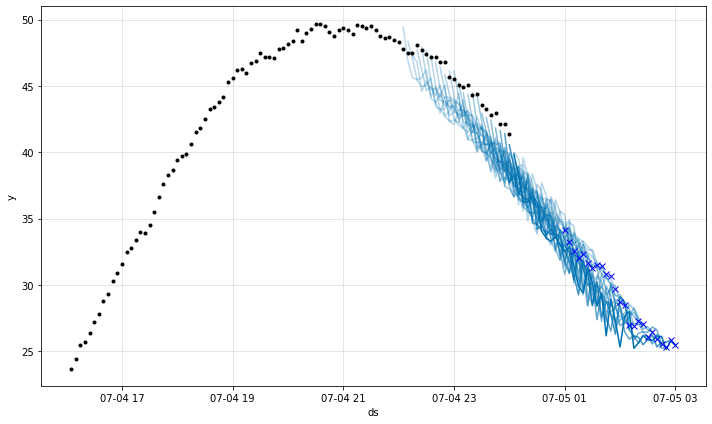

In [17]:
m = m.highlight_nth_step_ahead_of_each_forecast(3*12)
fig = m.plot_last_forecast(forecast, include_previous_forecasts=2*12)

## Larger forecast horizon
For predictions further into the future, you could reduce the resulution of the data.
Using a 5-minute resolution may be useful for a high-resolution short-term forecast, but counter-productive for a long-term forecast.
As we only have a limited amount of data (approx 2 months), we want to avoid over-specifying the model.

As an example: If we set the model to forecast 24 hours into the future (`nforecasts=24*12`) based on the last day's temperatures (`n_lags=24*12`), the number of parameters of our AR component grows to `24*12*24*12 = 82,944`. However, we only have about `2*30*24*12 = 17,280` samples in our dataset. The model would be overspecified.

If we first downsample our data to hourly data, we reduce our dataset to `2*30*24=1440` and our model parameters to `24*24=576`. Thus, we are able to fit the model. However, it would be better to collect more data.

In [18]:
df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])
df_hourly = df.set_index('ds', drop=False).resample('H').mean().reset_index()
len(df_hourly)

1561

In [19]:
df_hourly.head(3)

,ds,y
0,2017-05-01 00:00:00,24.891667
1,2017-05-01 01:00:00,16.741667
2,2017-05-01 02:00:00,11.733333


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 106
  0%|          | 0/106 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type          | Params
------------------------------------------------
0 | season_params | ParameterDict | 12    
1 | ar_net        | ModuleList    | 576   
2 | loss_func     | SmoothL1Loss  | 0     
------------------------------------------------
621       Trainable params
0         Non-trainable params
621       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

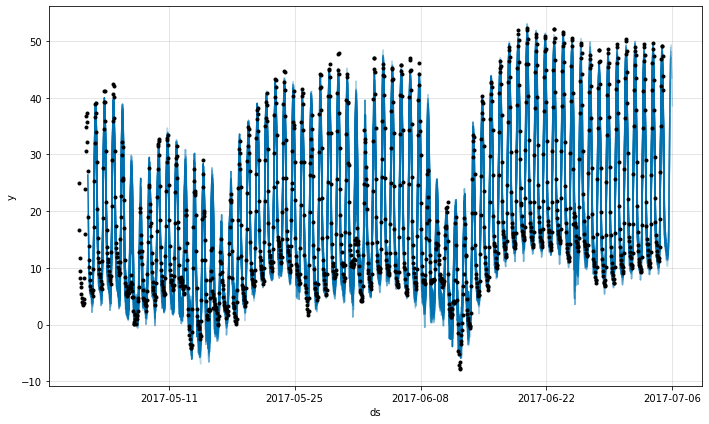

In [20]:
m = NeuralProphet(
    n_lags=24,
    n_forecasts=24,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    learning_rate=0.3,
)
metrics = m.fit(df_hourly, freq='H')
future = m.make_future_dataframe(df_hourly, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)
# fig_param = m.plot_parameters()

Finally, we plot the most recent and last ten historic 24-hour forecasts, marking the 24-th hour ahead with an 'x'.

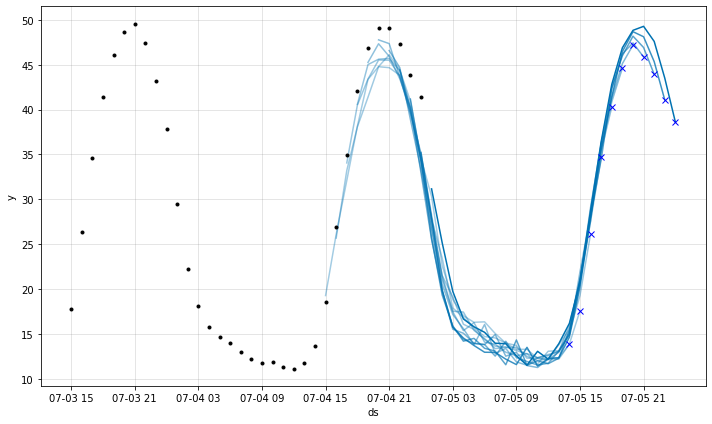

In [21]:
m = m.highlight_nth_step_ahead_of_each_forecast(24)
fig = m.plot_last_forecast(forecast, include_previous_forecasts=10)